# import

In [994]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import sys  # Add this import statement

logging.basicConfig(datefmt='%H:%M:%S',
                    stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(message)s')



# setup

In [995]:
# Distance away from the FBEWMA that data should be removed.
DELTA = 5

# clip data above this value:
HIGH_CLIP = 1000

# clip data below this value:
LOW_CLIP = 0

# random values above this trigger a spike:
# RAND_HIGH = 0.98

# random values below this trigger a negative spike:
# RAND_LOW = 0.02

# How many samples to run the FBEWMA over.
SPAN = 5
# spike amplitude
# SPIKE = 2

def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > HIGH_CLIP) | (np_unclipped < LOW_CLIP)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return np_clipped.tolist()

def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma
     
def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return np_remove_outliers

# removal function

In [996]:

def remove_spike(df, signal):
    df['rand'] = np.random.random_sample(len(df))
    df['y_clipped'] = clip_data(df[signal].tolist(), HIGH_CLIP, LOW_CLIP)
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()

    # Plot the data
    # df = df.iloc[:13780]
    plt.figure(figsize=(15, 5))

    
    
    # df = df.iloc[200000:245000]
    
    # Plot the data
    figsize=(15, 5)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    df.plot(x='Time(UTC+0)', y=signal, kind='line', color='blue', ax=ax)
    df.plot(x='Time(UTC+0)', y='y_interpolated', kind='line', color='black', ax=ax)
    ax.set_title(signal +' over Time(UTC+0)')
    ax.set_xlabel('Time(UTC+0)')
    ax.set_ylabel(signal)
    plt.tight_layout()
    plt.show()
    df[signal] = df['y_interpolated']
    columns_to_drop = ['y_interpolated', 'y_remove_outliers', 'y_ewma_fb', 'y_clipped', 'rand']
    df = df.drop(columns=columns_to_drop)
    return df


# spike dealing

<Figure size 1500x500 with 0 Axes>

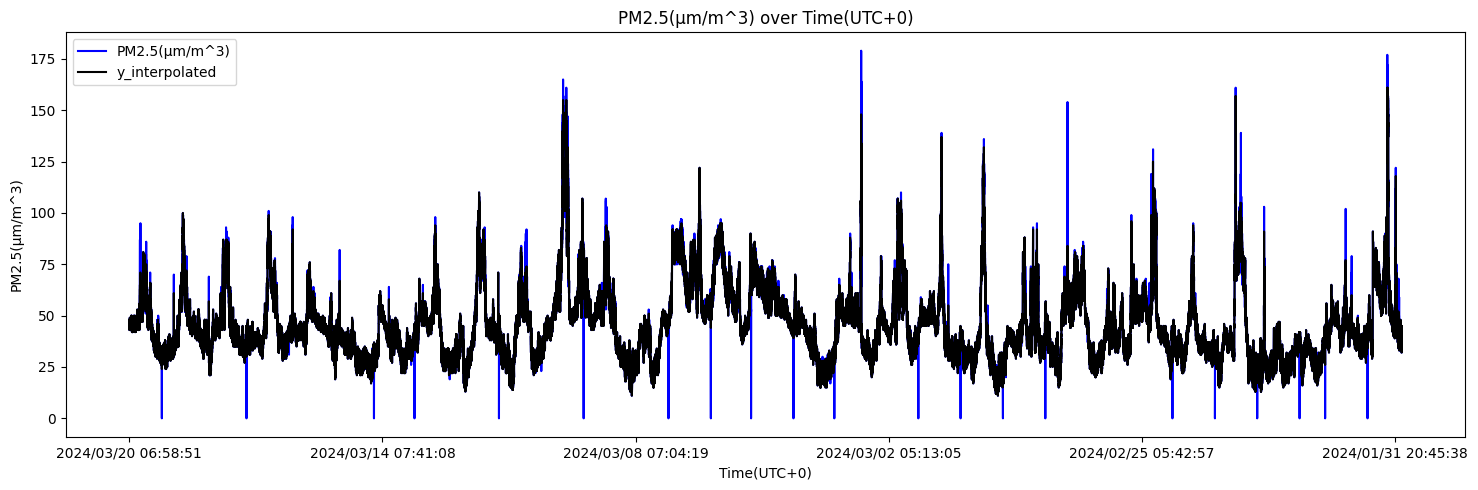

In [997]:
# Read your CSV file
csv_path = '../data/data.csv'  # Update with the actual path to your CSV file
df = pd.read_csv(csv_path)
df = remove_spike(df, 'PM2.5(μm/m^3)')

<Figure size 1500x500 with 0 Axes>

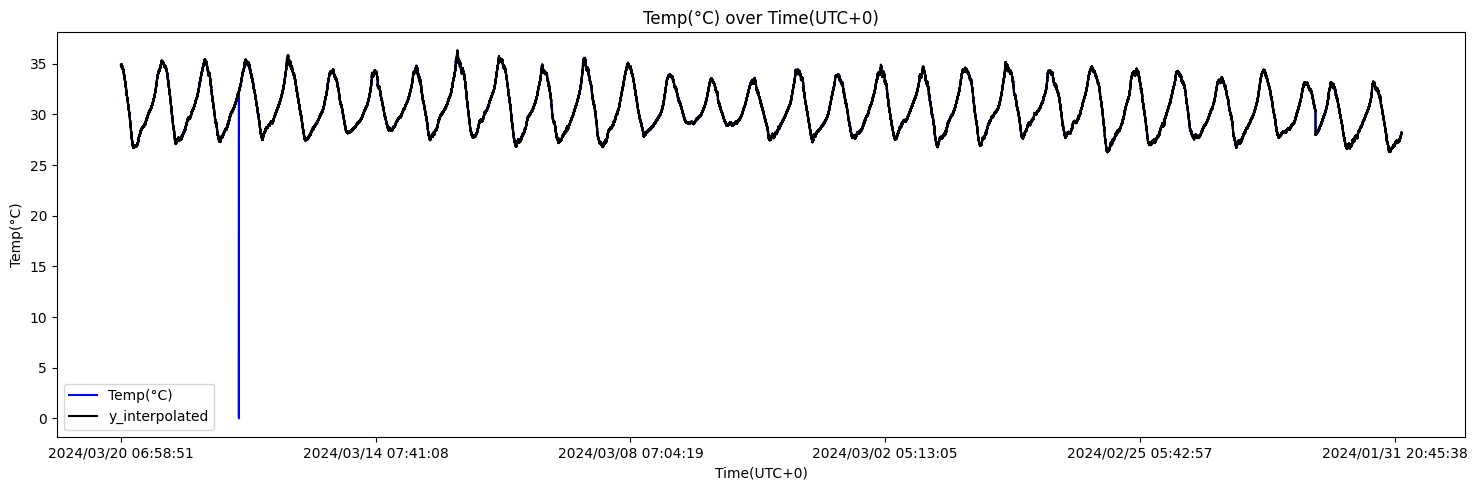

In [999]:
df = remove_spike(df, 'Temp(°C)')

<Figure size 1500x500 with 0 Axes>

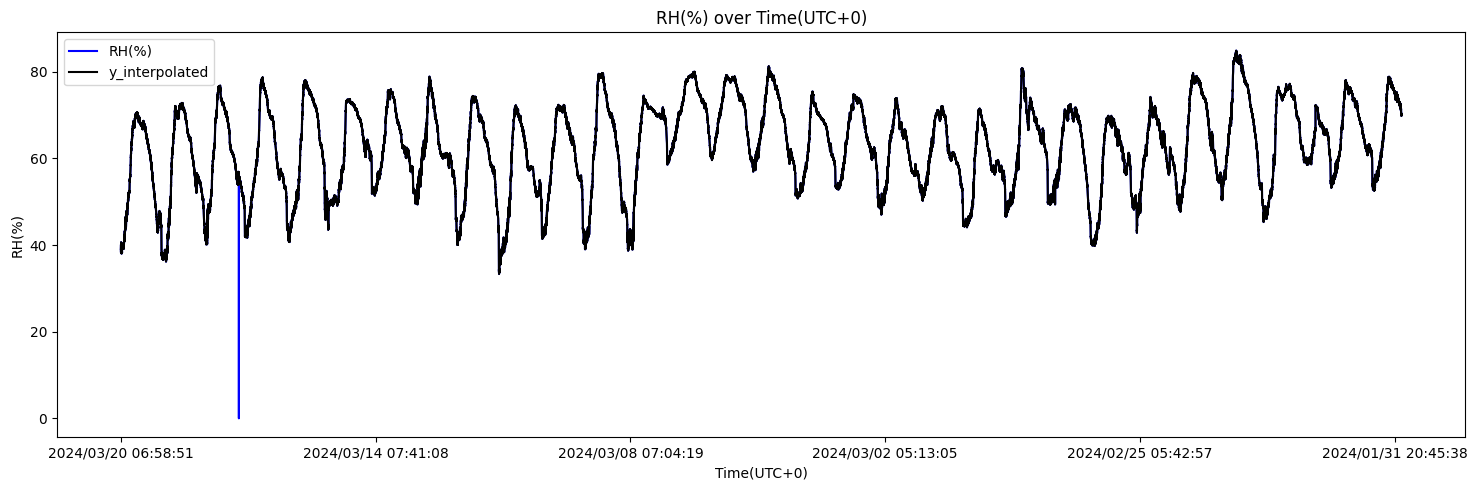

In [1000]:
df = remove_spike(df, 'RH(%)')

<Figure size 1500x500 with 0 Axes>

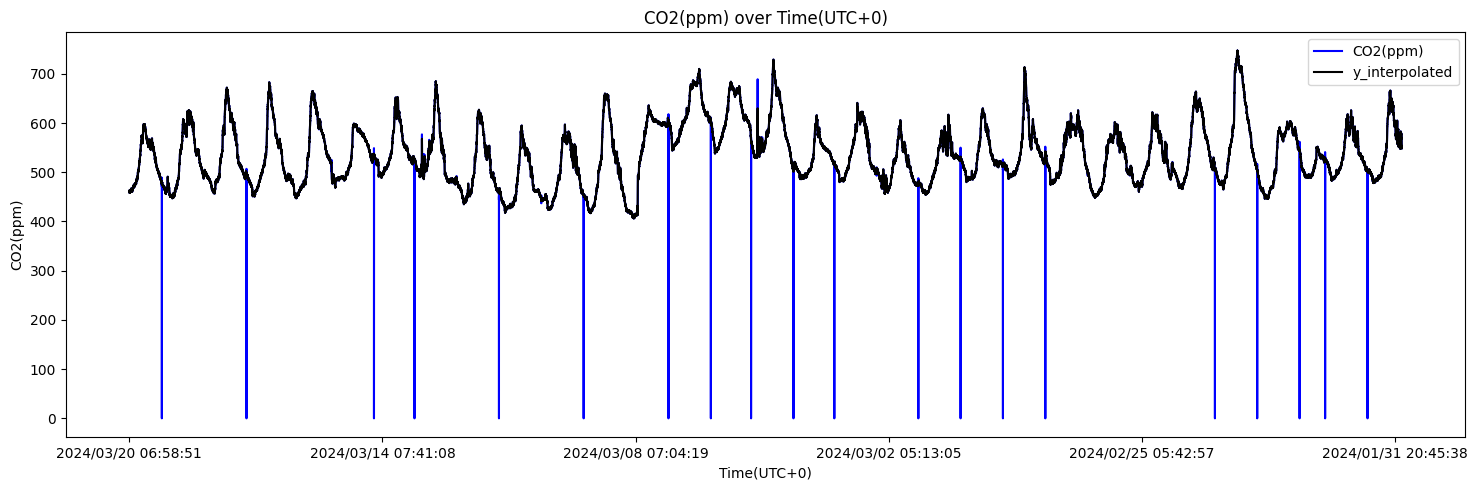

In [1001]:
df = remove_spike(df, 'CO2(ppm)')
df = df.dropna()

In [1002]:
df.to_csv(csv_path, index=False)